## Getting started
Upload needed libraries and setting up the dataset

In [ ]:
import os
import numpy as np
import pandas as pd

import bellatrex as btrex
print("Bellatrex version:", btrex.__version__)

PLOT_GUI = False

##########################################################################
root_folder = os.getcwd()
print(root_folder)

ImportError: Can't determine version for bottleneck

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split


from bellatrex.datasets import load_mtr_data, load_mlc_data
from bellatrex.datasets import load_survival_data, load_binary_data, load_regression_data
from bellatrex.utilities import get_auto_setup

# X, y = load_binary_data(return_X_y=True)
X, y = load_regression_data(return_X_y=True)
# X, y = load_survival_data(return_X_y=True)
# X, y = load_mlc_data(return_X_y=True)
# X, y = load_mtr_data(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Depending on the prediction task, we train a compatible Random Forest model.

In [ ]:
SETUP = get_auto_setup(y) # not necessary, but comfortable while swithcing between mnay prediction tasks
print('Detected prediction task \'SETUP\':', SETUP)

from sksurv.ensemble import RandomSurvivalForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

### instantiate original R(S)F estimator, works best with some pruning.
if SETUP.lower() in 'survival':
    clf = RandomSurvivalForest(n_estimators=100, min_samples_split=10,
                                n_jobs=-2, random_state=0)

elif SETUP.lower() in ['binary', 'multi-label']:
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=5,
                                n_jobs=-2, random_state=0)

elif SETUP.lower() in ['regression', 'multi-target']:
    clf = RandomForestRegressor(n_estimators=100, min_samples_split=5,
                                n_jobs=-2, random_state=0)


clf.fit(X_train, y_train)
print('Model fitting complete.')

Detected prediction task 'SETUP': regression
Model fitting complete.


In case the RF model to be explained is already trained externally, it can be loaded and packed with the following lines:

In [ ]:
from bellatrex.wrapper_class import pack_trained_ensemble

# Pretrained RF model should be packed as a list of dicts with the function below.
clf_packed = pack_trained_ensemble(clf)

The function `pack_trained_ensemble` stores a memory-efficient version of the model, making the model 
compatible not only with Bellatrex but also with [SHAP](https://shap.readthedocs.io/en/latest/)

The packed `clf_packed` model can now be passed into Bellatrex.

## Building Explanations
Now we can fit Bellatrex on the training data and run it on a few test samples
After fitting and tuning the explainer to a specific test instance, you can:
- `plot_overview()` to get a representation of the tree learners, and of the selected rules;
    GUI is available for this plotting method (set the paramter `plot_gui = True`).
- `plot_visuals()` to visualise the selected rules in a more use friendly way.

Model is already fitted, building explanation.
oracle_sample is: None
Automatically setting prediction task to: regression
Explaining sample i=0
best params: {'n_clusters': 3, 'n_dims': None, 'n_trees': 60}
Achieved fidelity: 0.9975
final trees indices: [38 51 42]
final cluster sizes: [23 11 26]
Bellatrex prediction: 19.2
Black box prediction: 19.17
##########################################################


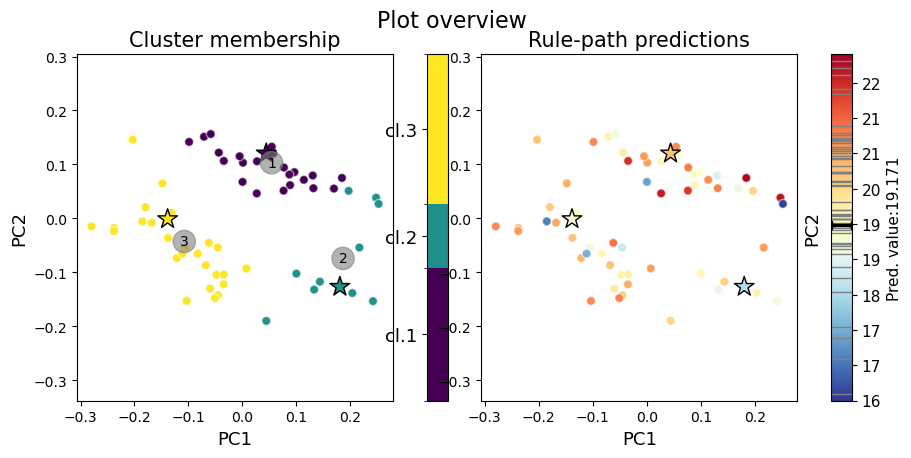

TypeError: BellatrexExplain.create_rules_txt() got an unexpected keyword argument 'print_rules'

In [ ]:
from bellatrex import BellatrexExplain
from bellatrex.utilities import predict_helper
import matplotlib.pyplot as plt

#fit RF here. The hyperparameters for fitting the explanation are given
# compatible with trained ensemble model clf, and with packed dictionary as in clf_packed
Btrex_fitted = BellatrexExplain(clf_packed, set_up='auto',
                                p_grid={"n_clusters": [1, 2, 3]},
                                verbose=3).fit(X_train, y_train)

N_TEST_SAMPLES = 2
for i in range(N_TEST_SAMPLES):

    print(f"Explaining sample i={i}")

    y_train_pred = predict_helper(clf, X_train) # calls, predict or predict_proba, depending on the underlying model

    tuned_method = Btrex_fitted.explain(X_test, i)

    fig1, axs1 = tuned_method.plot_overview(plot_gui=False,
                               show=True)
    plt.show(fig1)

    if SETUP.lower() in ['binary', 'regresssion', 'survival']:

        fig2, axs2 = tuned_method.plot_visuals(plot_max_depth=5,
                              preds_distr=y_train_pred,
                              conf_level=0.9,
                              tot_digits=4, show=False)
        plt.show(fig2)

    # Store rules in txt, then print the text explanation
    tuned_method.create_rules_txt()
    tuned_method.print_rules_txt()